## Group 15 - Contraceptive method used among Indonesian women

Kenna Roozendaal, Joy Cai, Naura Ambareswari

#### Introduction

Indonesia experienced a notable decline in its fertility rates between 1984 and 1987. The increased use of contraceptives is a significant factor in the drop in fertility due to more women gaining access to and awareness of available family planning resources compared to previous years. To better understand and address the declining fertility trend, the National Indonesia Contraceptive Prevalence Survey conducted a survey on family planning as well as collected women’s sociodemographic background.

The data taken from the survey will be used to answer the question “Given the wife's age, religion, and standard of living, what is the preferred contraceptive method used?”. We will be using the Contraceptive Method Choice Data Set that sampled married women in Indonesia who were not pregnant or were unaware they were pregnant (Lim, 1997). The goal was to predict women’s contraceptive method of choice (no use, long-term methods, short-term methods) based on characteristics like age, religion, standard of living, education, etc.

**Methods**

The dataset will be read into Python and the unused columns will be filtered out. Appropriate names will be given to the columns. The data will be split into a training and testing set, 75% for the training set and 25% for the testing set.

The columns used from the dataset are wife’s age, religion, education, standard of living, and contraceptive method used. Religion was chosen as a predictor because it influences the type of contraceptive used and Indonesia holds the largest Muslim population (Hefner, 2020; Hill et al., 2014). Education and age are predictors because age, socioeconomic level, and level of education, particularly educational lag, have been found to impact women’s contraceptive methods (Sámano et al., 2019). 

To create the most accurate predictor, the model will be tuned by testing different k-values for k-nearest neighbors. As such, a standard 5-fold-cross-validation will be conducted using the GridSearchCV method from the scikit-learn package. Using the best value for k, the model with maximized efficiency can be used.


**Expected outcomes and significance**

Women with a higher standard of living and higher education level tend to use contraceptives longer than other groups because they are more aware of the available family planning resources and other resources beyond what the government offers. Alternately, women with lower education levels and a lower standard of living are more likely to use contraceptives for a shorter period or not use them at all (Iseyemi et al., 2017). 

Predicting women’s contraceptive choice can help healthcare providers and policymakers ensure proper access to their preferred contraception. Identifying sociodemographic groups that use or do not use contraceptives can assess disparities in access, utilization, and education of contraception. Despite Indonesia’s decline in fertility, contraceptive use can lower rates of unplanned pregnancies as well as maternal and infant mortality. 
This research can further inquire on the accessibility of contraception and family planning for all sociodemographic groups in Indonesia, and how it can be improved in order to ensure equality and promote autonomy and control over women’s reproductive health. 


**Preliminary exploratory data analysis**

We first want to load the csv file into a dataframe so that we can better visualize the data. Appropriate headers are added and only the columns that have variables that are not related to the question are removed.

In [1]:
import altair as alt
import numpy as np
import pandas as pd
import sklearn
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

alt.data_transformers.disable_max_rows()
alt.renderers.enable("mimetype")

RendererRegistry.enable('mimetype')

In [2]:
cmc_dataset = pd.read_csv("data/cmc.data.csv", header=None,
                     names=[
                         "wife_age", 
                         "wife_education", #1=low 2,3,4=high
                         "husband_education", #1=low 2,3,4=high
                         "num_children_born",
                         "wife_religion", #0=not Islam 1=Islam
                         "wife_working", #0=yes 1=no
                         "husband_occupation", #1,2,3,4 (categorical)
                         "standard_of_living_index", #1=low 2,3,4=high
                         "media_exposure", #0=good 1=not good
                         "contraceptive_method_used", #1= no use 2=long-term 3=short-term
                     ]
                     )
cmc_dataset

,wife_age,wife_education,husband_education,num_children_born,wife_religion,wife_working,husband_occupation,standard_of_living_index,media_exposure,contraceptive_method_used
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1
...,...,...,...,...,...,...,...,...,...,...
1468,33,4,4,2,1,0,2,4,0,3
1469,33,4,4,3,1,1,1,4,0,3
1470,39,3,3,8,1,0,1,4,0,3
1471,33,3,3,4,1,0,2,2,0,3


In [3]:
cmc_dataset_filtered = cmc_dataset.loc[:, ["wife_age", "wife_education","wife_religion","standard_of_living_index", "contraceptive_method_used"]]
cmc_dataset_filtered

,wife_age,wife_education,wife_religion,standard_of_living_index,contraceptive_method_used
0,24,2,1,3,1
1,45,1,1,4,1
2,43,2,1,4,1
3,42,3,1,3,1
4,36,3,1,2,1
...,...,...,...,...,...
1468,33,4,1,4,3
1469,33,4,1,4,3
1470,39,3,1,4,3
1471,33,3,1,2,3


Now we want to split our data into a training and testing set. The preliminary data analysis will be an exploratory analysis that uses data from the training set only. In order to reduce human bias, only the training set will be visualized. For this project, the dataset will be split 75% training and 25% testing. 

In [4]:
cmc_train, cmc_test = train_test_split(cmc_dataset_filtered, test_size=0.25, random_state=123)
cmc_train.head()

,wife_age,wife_education,wife_religion,standard_of_living_index,contraceptive_method_used
1208,40,1,1,2,1
1297,35,4,1,4,2
736,19,3,1,3,3
186,20,2,1,2,1
1027,41,2,0,2,1


Now we want to know how many of each observation is in each class in order to provide the most equal split between different variables to ensure that one observation doesn't have a significantly larger influence on the results. 

In [5]:
cmc_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1104 entries, 1208 to 1389
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   wife_age                   1104 non-null   int64
 1   wife_education             1104 non-null   int64
 2   wife_religion              1104 non-null   int64
 3   standard_of_living_index   1104 non-null   int64
 4   contraceptive_method_used  1104 non-null   int64
dtypes: int64(5)
memory usage: 51.8 KB


In our preliminary analysis, we want to be able to summarize useful information about the training set in a table. As such, we want to be able to see if there is any missing data, and the means and medians of our predictor variables. 

In [6]:
variable_agg = cmc_train.agg(["mean", "median", "max", "min"])
variable_agg

,wife_age,wife_education,wife_religion,standard_of_living_index,contraceptive_method_used
mean,32.570652,2.950181,0.856884,3.130435,1.906703
median,32.000000,3.000000,1.000000,3.000000,2.000000
max,49.000000,4.000000,1.000000,4.000000,3.000000
min,16.000000,1.000000,0.000000,1.000000,1.000000


From the table above, we can see that the mean and median of each variable is similar, meaning that there is a good distribution of data.

In [7]:
missing_data = cmc_train.isna().sum()
missing_data

wife_age                     0
wife_education               0
wife_religion                0
standard_of_living_index     0
contraceptive_method_used    0
dtype: int64

We picked our variables using academic papers that have found a correlation between each variable and the method of contraception used. As such we want to be able to see if each variable demonstrates a clear correlation. 

**Wife's age**

/opt/conda/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


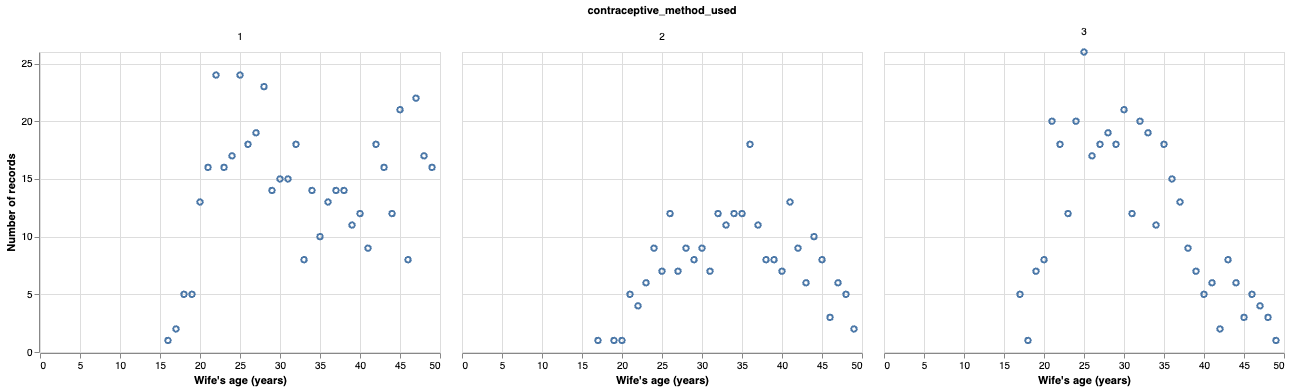

In [8]:
wife_age_correlation = alt.Chart(cmc_train, title = "Age vs. Method of Contraception Used").mark_point().encode(
    x = alt.X("wife_age", title = "Wife's age (years)"),
    y = alt.Y("count()", title = "Number of records")
).facet("contraceptive_method_used")
wife_age_correlation

**Wife's education**

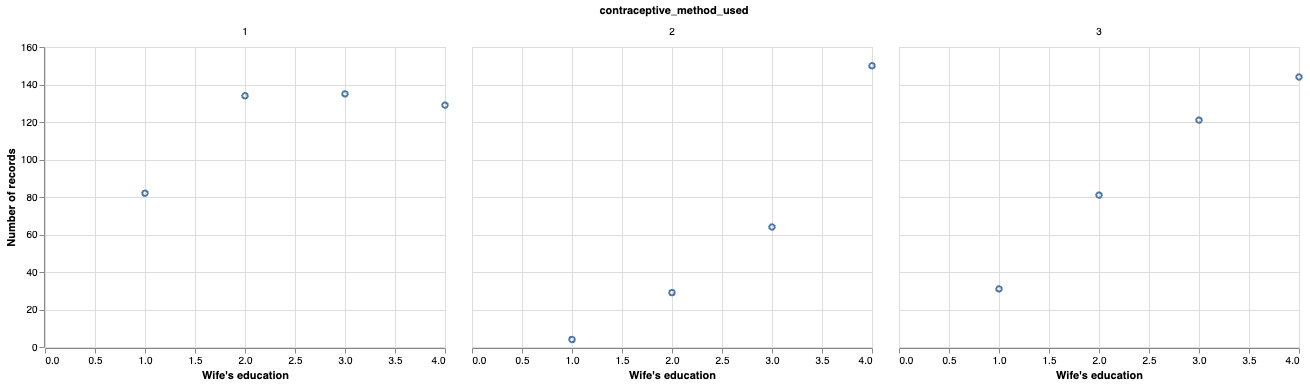

In [9]:
wife_education_correlation = alt.Chart(cmc_train, title = "Education vs. Method of Contraception Used").mark_point().encode(
    x = alt.X("wife_education", title = "Wife's education"),
    y = alt.Y("count()", title = "Number of records")
).facet("contraceptive_method_used")
wife_education_correlation

**Standard of living**

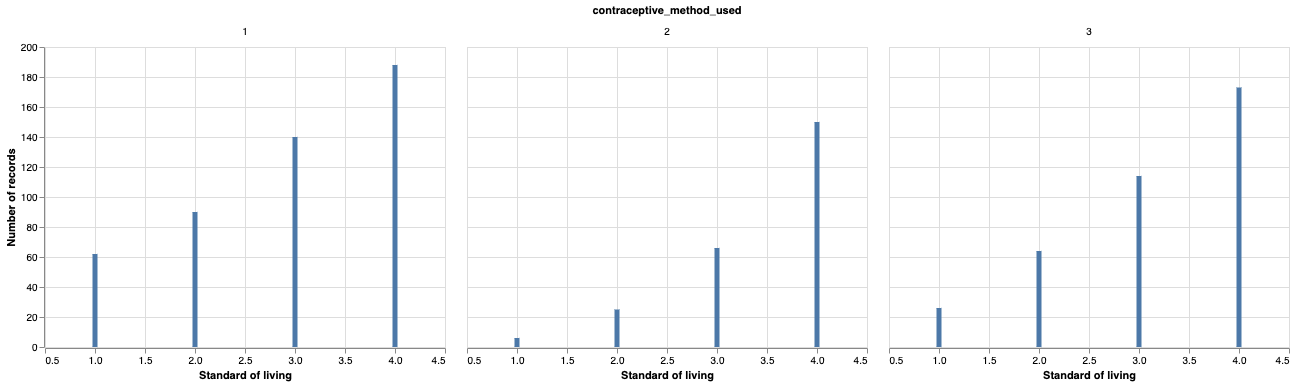

In [10]:
living_standard_correlation = alt.Chart(cmc_train, title = "Standard of living vs. Method of Contraception Used").mark_bar().encode(
    x = alt.X("standard_of_living_index", title = "Standard of living"),
    y = alt.Y("count()", title = "Number of records")
).facet("contraceptive_method_used")
living_standard_correlation

**Religion**

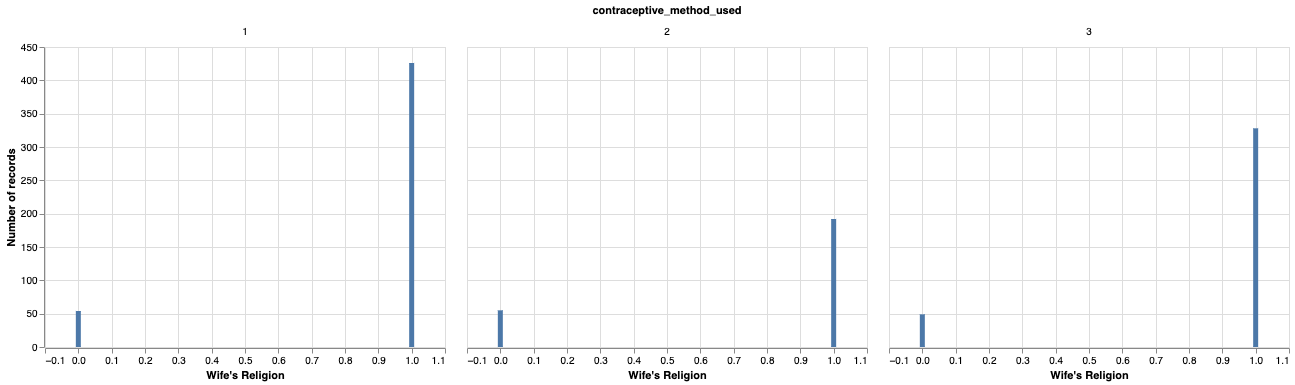

In [11]:
wife_religion_correlation = alt.Chart(cmc_train, title = "Religion vs. Method of Contraception Used").mark_bar().encode(
    x = alt.X("wife_religion", title = "Wife's Religion"),
    y = alt.Y("count()", title = "Number of records")
).facet("contraceptive_method_used")
wife_religion_correlation

**Resources**

Hefner, R. W. (2020). Islam and covenantal pluralism in Indonesia: A critical juncture analysis. The Review of Faith & International Affairs, 18(2), 1-17.

Hill, N. J., Siwatu, M., & Robinson, A. K. (2014). “My religion picked my birth control”: The influence of religion on contraceptive use. Journal of religion and health, 53, 825-833.

Iseyemi, A., Zhao, Q., McNicholas, C., & Peipert, J. F. (2017). Socioeconomic status as a risk factor for unintended pregnancy in the contraceptive CHOICE project. Obstetrics and gynecology, 130(3), 609.

Lim, T. (1997). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Sámano, R., Martínez-Rojano, H., Chico-Barba, G., Sánchez-Jiménez, B., Sam-Soto, S., Rodríguez-Ventura, A. L., ... & Sclavo-Melo, S. (2019). Sociodemographic factors associated with the knowledge and use of birth control methods in adolescents before and after pregnancy. International journal of environmental research and public health, 16(6), 1022.


In [99]:
print("hello")

hello
